In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np

from data_sequence import DataSequence
data_seq = DataSequence()

# To plot output of a layer.
def plot_layer_output(model, layer_i, x_batch, y_batch, img_idx=0, rows=6, cols=6):
    layer = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[layer_i].output)
    layer_visual = layer.predict(x_batch)
    print(layer_visual.shape)

    plt.figure(1, figsize=(20, 15))
    for i in range(layer_visual.shape[3]):
        
        if i > (rows*cols) - 1:
            break
            
        plt.subplot(rows, cols, i+1)
        img = layer_visual[img_idx, :, :, i]
        plt.imshow(img, cmap="jet")
        # plt.title(str(y_batch[i]))
        plt.axis("off")
        
        plt.colorbar()
        
# To plot loss and accuracy plots.
def plot_loss_acc(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history[0])
    plt.plot(history[2])
    plt.legend(["training", "validation"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss plot")

    plt.subplot(1, 2, 2)
    plt.plot(history[1])
    plt.plot(history[3])
    plt.legend(["training", "validation"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy plot")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 100, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 48, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 24, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 22, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 22, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 11, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 11, 64)         0

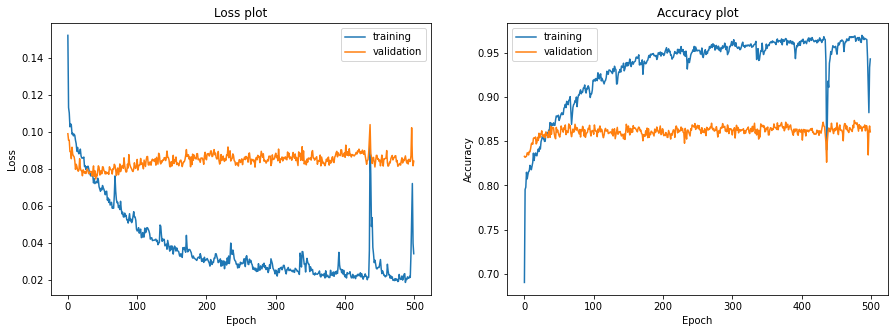

In [2]:
MODELS = ["forward", "left", "right"]  # Also represents the class names.
MODEL_I = 0  # Model index, determines which module to analyse, chosen from MODELS.

MODEL_TO_LOAD = "3_0_8_oldModel_baseL_moreEpochs"

EXTRA_DATA_SUBNAME = ""

BATCH_SIZE = 32

IMGS_SHAPE = (240, 320, 3)


with open(f"data/steering_frames_{MODELS[MODEL_I]}{EXTRA_DATA_SUBNAME}.npy", "rb") as file:
    all_x_data = np.load(file).astype(np.float32)
with open(f"data/steering_labels_{MODELS[MODEL_I]}{EXTRA_DATA_SUBNAME}.npy", "rb") as file:
    all_y_data = np.load(file)
    

rand_indicies = np.random.choice(all_x_data.shape[0], size=BATCH_SIZE, replace=False)
x_sample_batch = all_x_data[rand_indicies]
y_sample_batch = all_y_data[rand_indicies]
x_sample_batch, y_sample_batch = data_seq.pre_process_data(x_data=x_sample_batch, y_data=y_sample_batch)


model = load_model(f"saved_models/model_{MODELS[MODEL_I][:1]}_{MODEL_TO_LOAD}.h5")
model.summary()

with open(f"saved_models/history_{MODELS[MODEL_I][:1]}_{MODEL_TO_LOAD}.npy", "rb") as file:
    history = np.load(file)

plot_loss_acc(history)

# Visualise layer ouputs

In [ ]:
img_idx = 0

plot_layer_output(model, 0, x_sample_batch, y_sample_batch, img_idx=img_idx)

In [ ]:
plot_layer_output(model, 1, x_sample_batch, y_sample_batch, img_idx=img_idx)

In [ ]:
plot_layer_output(model, 2, x_sample_batch, y_sample_batch, img_idx=img_idx)

In [ ]:
plot_layer_output(model, 3, x_sample_batch, y_sample_batch, img_idx=img_idx)

In [ ]:
plot_layer_output(model, 4, x_sample_batch, y_sample_batch, img_idx=img_idx)

In [ ]:
plot_layer_output(model, 5, x_sample_batch, y_sample_batch, img_idx=img_idx)

In [ ]:
plot_layer_output(model, 7, x_sample_batch, y_sample_batch, img_idx=img_idx)

# Excracting the samples that were predicted incorrectly.

In [ ]:
n_wrong_samples = 0
wrong_imgs = []
wrong_imgs_labels = []

for i, img in enumerate(all_x_data):
    label = int(all_y_data[i]) - 1
    
    processed_input = data_seq.pre_process_input(img, model.inputs, convert_to_rgb=False)
    
    pred = model.predict(processed_input)
    pred = np.argmax(pred[0])
    
    if label != pred:
        n_wrong_samples += 1
        wrong_imgs.append(img)
        wrong_imgs_labels.append([label, pred])
        
    if i % 1000 == 0:
        print("Done", i, n_wrong_samples)
        

print("Number of wrong samples", n_wrong_samples)

wrong_imgs = np.array(wrong_imgs)
wrong_imgs_labels = np.array(wrong_imgs_labels)

print(wrong_imgs.shape)
print(wrong_imgs_labels.shape)

error_in_acc = n_wrong_samples / all_x_data.shape[0]
print((error_in_acc * 100), "error")
print(((1 - error_in_acc) * 100), "accuracy")

# If needed at a later stage.
with open(f"data/wrong_samples/wrong_imgs_{MODEL_TO_LOAD}.npy", "wb") as file: np.save(file, wrong_imgs)
with open(f"data/wrong_samples/wrong_imgs_labels{MODEL_TO_LOAD}.npy", "wb") as file: np.save(file, wrong_imgs_labels)
print("Saved")

### Visualising the wrong samples

In [ ]:
index = 0
while True:
    if index >= wrong_imgs.shape[0]: break
    
    img = wrong_imgs[index]
    label_pred = wrong_imgs_labels[index]
    index += 1
    
    
    cv2.putText(img, str(label_pred), (50, 50), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), thickness=3)
    
    cv2.imshow("Wrong images", img)
    
    if cv2.waitKey(30) == ord('q'):
        break

        
cv2.destroyAllWindows()